# Cross Validation — wersja skrócona i praktyczna (TensorFlow i PyTorch)

Ten notatnik został uproszczony. Na początku znajdziesz bardzo krótkie, działające przykłady k‑fold cross validation dla prostego problemu klasyfikacji (Iris) w TensorFlow/Keras i w PyTorch. Każdy przykład liczy accuracy dla każdego folda i rysuje prosty wykres z interpretacją. Dalej pozostawiono bardziej rozbudowane materiały dla chętnych.

Czym jest k‑fold CV? Dzielimy dane na k równych części (foldów). Uczymy model k razy: za każdym razem na (k−1) foldach, a testujemy na pozostałym. Średnia z wyników to stabilniejsza estymacja jakości niż pojedynczy train/val split.

Najważniejsze zasady w DL:
- Nowy model dla każdego folda (nie przenosimy wag).
- Normalizację/standaryzację dopasowujemy wyłącznie na danych treningowych folda, a potem transformujemy walidację.
- Ustaw seedy (powtarzalność) i użyj krótkiego treningu.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


## Przykład 1: TensorFlow/Keras — krótka k‑fold CV na Iris

- Dane: 150 próbek, 4 cechy, 3 klasy.
- Model: niewielka sieć MLP (1 warstwa ukryta).
- Trening: kilka epok na fold (szybko i lekko). 

Po każdym foldzie zapisujemy accuracy. Na końcu rysujemy wykres słupkowy i opisujemy interpretację.


Fold 1: accuracy = 1.000
Fold 2: accuracy = 0.967
Fold 3: accuracy = 0.867
Fold 4: accuracy = 1.000
Fold 5: accuracy = 0.900


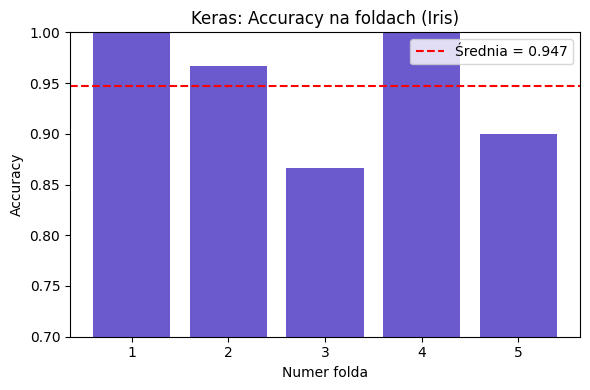

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(42)
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

X, y = load_iris(return_X_y=True)

k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
fold_acc = []

for i, (tr_idx, va_idx) in enumerate(kf.split(X, y), start=1):
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X[tr_idx])
    X_va = scaler.transform(X[va_idx])

    model = keras.Sequential([
        layers.Input(shape=(X.shape[1],)),
        layers.Dense(16, activation="relu"),
        layers.Dense(3, activation="softmax"),
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    model.fit(X_tr, y[tr_idx], epochs=20, batch_size=16, verbose=0)
    preds = np.argmax(model.predict(X_va, verbose=0), axis=1)
    acc = accuracy_score(y[va_idx], preds)
    fold_acc.append(acc)
    print(f"Fold {i}: accuracy = {acc:.3f}")

mean_acc = np.mean(fold_acc)
std_acc = np.std(fold_acc)

plt.figure(figsize=(6,4))
plt.bar(range(1, k+1), fold_acc, color="#6A5ACD")
plt.axhline(mean_acc, color="red", linestyle="--", label=f"Średnia = {mean_acc:.3f}")
plt.title("Keras: Accuracy na foldach (Iris)")
plt.xlabel("Numer folda")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.0)
plt.legend()
plt.tight_layout()
plt.show()


Interpretacja wykresu: Każdy słupek to accuracy na jednym foldzie (różne podziały uczą/walidują model). Czerwona linia przerywana to średnia accuracy — traktujemy ją jako główną miarę jakości modelu. Rozrzut słupków (odchylenie) informuje o wrażliwości na podział danych.


## Przykład 2: PyTorch — krótka k‑fold CV na Iris

Analogiczna procedura, ale z ręczną pętlą uczącą w PyTorch. Model to małe MLP, a na końcu rysujemy wykres accuracy.


In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(42)

def make_model(input_dim=4, hidden=16, num_classes=3):
    return nn.Sequential(
        nn.Linear(input_dim, hidden),
        nn.ReLU(),
        nn.Linear(hidden, num_classes),
    )

k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
fold_acc_pt = []

for i, (tr_idx, va_idx) in enumerate(kf.split(X, y), start=1):
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X[tr_idx]).astype(np.float32)
    X_va = scaler.transform(X[va_idx]).astype(np.float32)
    y_tr = y[tr_idx].astype(np.int64)
    y_va = y[va_idx].astype(np.int64)

    train_ds = TensorDataset(torch.tensor(X_tr), torch.tensor(y_tr))
    val_ds = TensorDataset(torch.tensor(X_va), torch.tensor(y_va))
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

    model = make_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    model.train()
    for epoch in range(20):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X_va))
        preds = logits.argmax(dim=1).numpy()
    acc = (preds == y_va).mean()
    fold_acc_pt.append(acc)
    print(f"Fold {i}: accuracy = {acc:.3f}")

mean_acc_pt = float(np.mean(fold_acc_pt))

plt.figure(figsize=(6,4))
plt.bar(range(1, k+1), fold_acc_pt, color="#20B2AA")
plt.axhline(mean_acc_pt, color="red", linestyle="--", label=f"Średnia = {mean_acc_pt:.3f}")
plt.title("PyTorch: Accuracy na foldach (Iris)")
plt.xlabel("Numer folda")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.0)
plt.legend()
plt.tight_layout()
plt.show()


Interpretacja wykresu: Słupki pokazują wyniki na poszczególnych foldach w PyTorchu; czerwona linia to średnia. Jeśli rozrzut jest mały i średnia wysoka, model jest stabilny i dobrze generalizuje na tym zbiorze.


---

Poniżej pozostawiono wcześniejszą, bardziej rozbudowaną część notatnika (sklearn, warianty itp.). Możesz ją pominąć, jeśli szukasz tylko krótkich przykładów.


## Cross Validation w uczeniu klasycznym i deep learningu

### Co jest dostępne od ręki, a co trzeba napisać samemu?

1. **scikit-learn**
   - Gotowe narzędzia: `cross_val_score`, `GridSearchCV`, `StratifiedKFold`
   - Wystarczy przekazać estimator; biblioteka zadba o podziały i metryki

2. **PyTorch**
   - Brak wbudowanego CV; korzystamy z `KFold`/`StratifiedKFold` do dzielenia indeksów
   - Dla każdego fold-u tworzymy świeży model, DataLoader i pętlę treningową
   - Możemy łatwo sterować urządzeniem (CPU/GPU), funkcjami straty itd.

3. **TensorFlow / Keras**
   - Podobnie jak w PyTorch – implementujemy pętlę sami
   - Keras udostępnia wygodny interfejs `model.fit`, więc w praktyce wystarczy pętla po foldach i ręczne przerzucanie danych

### Najważniejsze zasady przy CV w deep learningu

- **Nowy model dla każdego fold-u** – nie przenosimy wag pomiędzy foldami
- **Oddzielna normalizacja** – transformacje (np. standaryzacja) dopasowujemy tylko na danych treningowych danego fold-u
- **Kontrola losowości** – ustaw seedy dla NumPy / PyTorch / TensorFlow
- **Monitorowanie uczenia** – warto logować przebieg strat i korzystać z early stoppingu
- **Sprzątanie pamięci** – przy GPU warto po każdym foldzie wywołać `torch.cuda.empty_cache()` / `tf.keras.backend.clear_session()`

Poniżej znajdziesz przykłady: najpierw klasyczne użycie scikit-learn, a następnie minimalistyczne implementacje dla TensorFlow/Keras oraz PyTorch – wszystko bez dodatkowych wrapperów.


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler


def keras_cross_validation(
    X,
    y,
    k=5,
    epochs=50,
    batch_size=32,
    hidden_size=128,
    dropout_rate=0.3,
    lr=0.001,
    verbose=True,
):
    """
    K-Fold Cross Validation dla modeli Keras
    """
    # Przygotowanie danych
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    y_categorical = to_categorical(y, num_classes=10)

    # K-Fold
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    cv_scores = []

    if verbose:
        print(f"=== KERAS {k}-FOLD CROSS VALIDATION ===")

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        if verbose:
            print(f"Fold {fold + 1}/{k}...")

        # Podział danych
        X_train_fold = X_scaled[train_idx]
        X_val_fold = X_scaled[val_idx]
        y_train_fold = y_categorical[train_idx]
        y_val_fold = y_categorical[val_idx]

        # Tworzenie nowego modelu dla każdego fold-a
        model = create_keras_model(
            input_dim=X_scaled.shape[1],
            hidden_size=hidden_size,
            dropout_rate=dropout_rate,
            lr=lr,
        )

        # Trening modelu
        history = model.fit(
            X_train_fold,
            y_train_fold,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_val_fold, y_val_fold),
            verbose=0,  # Cicha praca
        )

        # Ewaluacja
        val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        cv_scores.append(val_accuracy)

        if verbose:
            print(f"  Fold {fold + 1} accuracy: {val_accuracy:.4f}")

    cv_scores = np.array(cv_scores)

    if verbose:
        print(f"\\nWyniki Cross Validation:")
        print(f"Średnia accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        print(f"Zakres: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")

    return cv_scores

### Implementacja Cross Validation dla TensorFlow/Keras

In [ ]:
def create_keras_model(input_dim=64, hidden_size=128, dropout_rate=0.3, lr=0.001):
    """
    Funkcja tworząca model Keras
    """
    model = Sequential(
        [
            Dense(hidden_size, activation="relu", input_dim=input_dim),
            Dropout(dropout_rate),
            Dense(hidden_size, activation="relu"),
            Dropout(dropout_rate),
            Dense(10, activation="softmax"),  # 10 klas
        ]
    )

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


# Test modelu

model = create_keras_model()
print("Model TensorFlow/Keras:")
model.summary()

# Test forward pass
sample_input = np.random.random((1, 64))
output = model.predict(sample_input, verbose=0)
print(f"Kształt wyjścia: {output.shape}")
print(f"Suma prawdopodobieństw: {output.sum():.4f}")

### Definicja modelu TensorFlow/Keras

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Import bibliotek TensorFlow/Keras


print(f"TensorFlow wersja: {tf.__version__}")
print(f"GPU dostępne: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Wyłączenie ostrzeżeń TensorFlow
tf.get_logger().setLevel("ERROR")


# Przygotowanie danych dla TensorFlow
if "X_digits" not in globals():
    from sklearn.datasets import load_digits

    digits = load_digits()
    X_digits, y_digits = digits.data, digits.target

X_digits_scaled = StandardScaler().fit_transform(X_digits)
y_digits_categorical = to_categorical(y_digits, num_classes=10)

print(f"Kształt danych X: {X_digits_scaled.shape}")
print(f"Kształt danych y: {y_digits_categorical.shape}")

---

## 9. Cross Validation w TensorFlow/Keras

TensorFlow/Keras również nie ma wbudowanego mechanizmu cross validation, ale można łatwo zintegrować sklearn's KFold z modelami Keras.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class DigitsClassifier(nn.Module):
    def __init__(self, hidden_size=64, dropout_rate=0.3):
        super(DigitsClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(64, hidden_size),   # 64 cechy wejściowe w digits
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 10)    # 10 klas cyfr
        )

    def forward(self, x):
        return self.net(x)

def pytorch_hyperparameter_search(X, y, param_grid, k=5):
    """
    Grid search z Cross Validation dla PyTorch
    """
    best_score = 0
    best_params = None
    results = []

    print("=== PYTORCH HYPERPARAMETER SEARCH ===")

    # Generowanie wszystkich kombinacji parametrów
    from itertools import product

    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())

    for params in product(*param_values):
        param_dict = dict(zip(param_names, params))
        print(f"\\nTestowanie parametrów: {param_dict}")

        # Przekazanie parametrów do funkcji CV
        scores = pytorch_cross_validation_params(X, y, k=k, **param_dict, verbose=False)
        mean_score = scores.mean()

        results.append(
            {
                "params": param_dict.copy(),
                "scores": scores,
                "mean_score": mean_score,
                "std_score": scores.std(),
            }
        )

        print(f"Średni wynik: {mean_score:.4f} ± {scores.std():.4f}")

        if mean_score > best_score:
            best_score = mean_score
            best_params = param_dict.copy()

    print(f"\\n=== NAJLEPSZE PARAMETRY ===")
    print(f"Parametry: {best_params}")
    print(f"Wynik: {best_score:.4f}")

    return best_params, results


def pytorch_cross_validation_params(
    X,
    y,
    k=5,
    hidden_size=128,
    dropout_rate=0.3,
    lr=0.001,
    epochs=50,
    batch_size=32,
    verbose=True,
):
    """
    Cross validation z możliwością ustawiania parametrów
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_tensor = torch.FloatTensor(X_scaled)
    y_tensor = torch.LongTensor(y)
    dataset = TensorDataset(X_tensor, y_tensor)

    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    cv_scores = []

    if verbose:
        print(
            f"=== PYTORCH CV - Hidden: {hidden_size}, Dropout: {dropout_rate}, LR: {lr} ==="
        )

    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        if verbose:
            print(f"Fold {fold + 1}/{k}...")

        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

        # Model z podanymi parametrami
        model = DigitsClassifier(hidden_size=hidden_size, dropout_rate=dropout_rate).to(
            device
        )
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        model = train_model_pytorch(model, train_loader, criterion, optimizer, epochs)
        accuracy = evaluate_model_pytorch(model, test_loader)
        cv_scores.append(accuracy)

        if verbose:
            print(f"  Fold {fold + 1} accuracy: {accuracy:.4f}")

    cv_scores = np.array(cv_scores)

    if verbose:
        print(f"Średnia accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    return cv_scores

def train_model_pytorch(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

def evaluate_model_pytorch(model, test_loader):
    """
    Ocena modelu na zbiorze testowym.
    Zwraca accuracy (odsetek poprawnych klasyfikacji).
    """
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return correct / total


# Definicja siatki parametrów
param_grid = {
    "hidden_size": [64, 128, 256],
    "dropout_rate": [0.2, 0.3, 0.5],
    "lr": [0.001, 0.01],
}

# Uruchomienie grid search (ograniczone dla czasu wykonania)
print("Uruchamianie skróconej wersji grid search...")
limited_param_grid = {
    "hidden_size": [64, 128],
    "dropout_rate": [0.3],
    "lr": [0.001, 0.01],
}

best_params, search_results = pytorch_hyperparameter_search(
    X_digits, y_digits, limited_param_grid, k=3
)

### Tuning hiperparametrów w PyTorch z Cross Validation

In [ ]:
# Porównanie z modelami scikit-learn na tym samym zbiorze danych
sklearn_models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
}

sklearn_results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Obliczenie wyników dla PyTorch NN
pytorch_scores = pytorch_cross_validation_params(
    X_digits,
    y_digits,
    k=5,                 # liczba foldów (żeby było porównywalne ze sklearn)
    hidden_size=128,
    dropout_rate=0.3,
    lr=0.001,
    epochs=20,
    batch_size=32,
    verbose=False
)

print("=== PORÓWNANIE PYTORCH Z SCIKIT-LEARN ===")

# Cross validation dla modeli sklearn
for name, model in sklearn_models.items():
    # Normalizacja dla SVM i Logistic Regression
    data_to_use = (
        StandardScaler().fit_transform(X_digits)
        if name in ["SVM", "Logistic Regression"]
        else X_digits
    )

    scores = cross_val_score(model, data_to_use, y_digits, cv=skf, scoring="accuracy")
    sklearn_results[name] = scores

    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")

print(f"PyTorch NN: {pytorch_scores.mean():.4f} ± {pytorch_scores.std():.4f}")

# Wizualizacja porównania
all_results = sklearn_results.copy()
all_results["PyTorch NN"] = pytorch_scores

plt.figure(figsize=(12, 6))
plt.boxplot(all_results.values(), labels=all_results.keys())
plt.ylabel("Accuracy")
plt.title("Porównanie PyTorch z scikit-learn (Digits dataset)")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Ranking modeli
model_ranking = sorted(all_results.items(), key=lambda x: x[1].mean(), reverse=True)
print("\n=== RANKING MODELI ===")
for i, (name, scores) in enumerate(model_ranking):
    print(f"{i+1}. {name}: {scores.mean():.4f} ± {scores.std():.4f}")

### Porównanie z scikit-learn na tym samym zbiorze danych

In [ ]:
from sklearn.preprocessing import StandardScaler


def train_model_pytorch(model, train_loader, criterion, optimizer, epochs=50):
    """
    Funkcja trenująca model PyTorch
    """
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
    
    return model

def evaluate_model_pytorch(model, test_loader):
    """
    Funkcja ewaluująca model PyTorch
    """
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    return accuracy

def pytorch_cross_validation(X, y, k=5, epochs=50, batch_size=32, lr=0.001):
    """
    Implementacja K-Fold Cross Validation dla PyTorch
    """
    # Normalizacja danych
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Konwersja do tensorów
    X_tensor = torch.FloatTensor(X_scaled)
    y_tensor = torch.LongTensor(y)
    
    # Tworzenie datasetu
    dataset = TensorDataset(X_tensor, y_tensor)
    
    # K-Fold
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    cv_scores = []
    
    print(f"=== PYTORCH {k}-FOLD CROSS VALIDATION ===")
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        print(f"Fold {fold + 1}/{k}...")
        
        # Tworzenie subset-ów
        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)
        
        # DataLoaders
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
        
        # Nowy model dla każdego fold-a
        model = DigitsClassifier().to(device)      
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Trening
        model = train_model_pytorch(model, train_loader, criterion, optimizer, epochs)
        
        # Ewaluacja
        accuracy = evaluate_model_pytorch(model, test_loader)
        cv_scores.append(accuracy)
        
        print(f"  Fold {fold + 1} accuracy: {accuracy:.4f}")
    
    cv_scores = np.array(cv_scores)
    print(f"\nWyniki Cross Validation:")
    print(f"Średnia accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"Zakres: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")
    
    return cv_scores

# Uruchomienie PyTorch Cross Validation
pytorch_scores = pytorch_cross_validation(X_digits, y_digits, k=5, epochs=50)

### Porównanie wyników PyTorch i TensorFlow/Keras

In [ ]:

keras_scores = keras_cross_validation(X_digits, y_digits, k=5, epochs=30)
print("=== PORÓWNANIE PYTORCH VS KERAS ===")
print(f"PyTorch NN: {pytorch_scores.mean():.4f} ± {pytorch_scores.std():.4f}")
print(f"Keras NN:   {keras_scores.mean():.4f} ± {keras_scores.std():.4f}")

frameworks_comparison = {
    'PyTorch': pytorch_scores,
    'TensorFlow/Keras': keras_scores,
}

plt.figure(figsize=(8, 6))
plt.boxplot(frameworks_comparison.values(), labels=frameworks_comparison.keys())
plt.ylabel('Accuracy')
plt.title('Porównanie PyTorch vs TensorFlow/Keras')
plt.grid(True, alpha=0.3)
plt.show()


### Implementacja Cross Validation dla PyTorch

In [ ]:
class DigitsClassifier(nn.Module):
    def __init__(
        self, input_size=64, hidden_size=128, num_classes=10, dropout_rate=0.3
    ):
        super(DigitsClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


# Test modelu
model = DigitsClassifier()
print("Model PyTorch:")
print(model)
print(f"Liczba parametrów: {sum(p.numel() for p in model.parameters())}")

# Przykład forward pass
sample_input = torch.randn(1, 64)
output = model(sample_input)
print(f"Kształt wyjścia: {output.shape}")

### Definicja modelu PyTorch

In [ ]:
# Import dodatkowych bibliotek dla PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset, TensorDataset

# Sprawdźmy czy CUDA jest dostępne
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")

# Ładowanie większego zbioru danych - MNIST-like digits
digits = load_digits()
X_digits, y_digits = digits.data, digits.target

print(f"Kształt danych Digits: {X_digits.shape}")
print(f"Liczba klas: {len(np.unique(y_digits))}")
print(f"Zakres pikseli: [{X_digits.min()}, {X_digits.max()}]")

## 8. Cross Validation w PyTorch

W PyTorch nie ma wbudowanych narzędzi do cross validation jak w scikit-learn, ale możemy łatwo zaimplementować tę funkcjonalność używając `KFold` z sklearn oraz PyTorch-owych modeli.

# Cross Validation (Walidacja Krzyżowa)

## Co to jest Cross Validation?

Cross Validation (walidacja krzyżowa) to technika ewaluacji modeli uczenia maszynowego, która pozwala na bardziej wiarygodną ocenę wydajności modelu poprzez wielokrotne dzielenie danych na zbiory treningowe i walidacyjne.

## Dlaczego Cross Validation jest ważna?

### Problemy z prostym podziałem train/test:
- **Zależność od konkretnego podziału** - wynik może się różnić w zależności od tego, które dane trafiły do zbioru testowego
- **Mała reprezentatywność** - szczególnie przy małych zbiorach danych
- **Overfitting do zbioru testowego** - gdy wielokrotnie testujemy różne modele na tym samym zbiorze

### Zalety Cross Validation:
- **Bardziej stabilne wyniki** - każda próbka jest używana zarówno do treningu jak i testowania
- **Lepsza ocena wydajności** - otrzymujemy średnią i odchylenie standardowe
- **Efektywne wykorzystanie danych** - szczególnie ważne przy małych zbiorach
- **Redukcja overfittingu** - model jest testowany na różnych podzbiorach danych

## Import bibliotek

In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_breast_cancer, load_iris, load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_val_score,
    learning_curve,
    train_test_split,
    validation_curve,
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

warnings.filterwarnings("ignore")

# Ustawienia dla wykresów
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

## Przygotowanie danych testowych

In [ ]:
# Ładowanie różnych zbiorów danych
iris = load_iris()
wine = load_wine()
cancer = load_breast_cancer()

# Dla przykładu użyjemy zbioru Iris
X, y = iris.data, iris.target

print(f"Kształt danych: {X.shape}")
print(f"Liczba klas: {len(np.unique(y))}")
print(f"Klasy: {iris.target_names}")
print(f"Cechy: {iris.feature_names}")

# Sprawdźmy rozkład klas
unique, counts = np.unique(y, return_counts=True)
print(f"\nRozkład klas: {dict(zip(iris.target_names, counts))}")

## 1. Porównanie: Prosty podział vs Cross Validation

In [ ]:
# Prosty podział train/test
def simple_train_test_split_evaluation(X, y, n_splits=10, random_state=42):
    """
    Porównanie wyników przy różnych losowych podziałach train/test
    """
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = []

    for i in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=i
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)

    return np.array(scores)


# Cross Validation
def cross_validation_evaluation(X, y, cv=10):
    """
    Ewaluacja używając cross validation
    """
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    return scores


# Porównanie wyników
simple_scores = simple_train_test_split_evaluation(X, y)
cv_scores = cross_validation_evaluation(X, y)

print("=== PORÓWNANIE METOD EWALUACJI ===")
print(f"\nProsty podział train/test (10 różnych podziałów):")
print(f"Średnia accuracy: {simple_scores.mean():.4f} ± {simple_scores.std():.4f}")
print(f"Zakres: [{simple_scores.min():.4f}, {simple_scores.max():.4f}]")

print(f"\n10-Fold Cross Validation:")
print(f"Średnia accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Zakres: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")

# Wizualizacja
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.boxplot([simple_scores, cv_scores], labels=["Train/Test Split", "Cross Validation"])
plt.ylabel("Accuracy")
plt.title("Porównanie stabilności wyników")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(
    range(1, len(simple_scores) + 1),
    simple_scores,
    "o-",
    label="Train/Test Split",
    alpha=0.7,
)
plt.plot(
    range(1, len(cv_scores) + 1), cv_scores, "s-", label="Cross Validation", alpha=0.7
)
plt.xlabel("Iteracja/Fold")
plt.ylabel("Accuracy")
plt.title("Wyniki w poszczególnych iteracjach")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Rodzaje Cross Validation

### K-Fold Cross Validation

In [ ]:
def visualize_kfold_splits(X, y, k=5):
    """
    Wizualizacja podziałów w K-Fold CV
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    fig, axes = plt.subplots(k, 1, figsize=(12, 2 * k))
    if k == 1:
        axes = [axes]

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Tworzenie wizualizacji podziału
        split_viz = np.zeros(len(X))
        split_viz[train_idx] = 1  # trening = 1
        split_viz[test_idx] = 2  # test = 2

        # Kolorowanie według klas
        colors = ["lightgray", "lightblue", "lightcoral"]

        axes[fold].scatter(
            range(len(X)),
            [fold] * len(X),
            c=[colors[int(val)] for val in split_viz],
            s=50,
            alpha=0.8,
        )
        axes[fold].set_title(
            f"Fold {fold + 1}: Train ({len(train_idx)} próbek) vs Test ({len(test_idx)} próbek)"
        )
        axes[fold].set_xlabel("Indeks próbki")
        axes[fold].set_yticks([])
        axes[fold].grid(True, alpha=0.3)

    # Legenda
    from matplotlib.patches import Patch

    legend_elements = [
        Patch(facecolor="lightblue", label="Trening"),
        Patch(facecolor="lightcoral", label="Test"),
    ]
    fig.legend(handles=legend_elements, loc="upper right")

    plt.tight_layout()
    plt.show()


# Wizualizacja 5-Fold CV
print("=== K-FOLD CROSS VALIDATION ===")
print("Wizualizacja podziałów w 5-Fold Cross Validation:")
visualize_kfold_splits(X, y, k=5)

# Porównanie różnych wartości k
k_values = [3, 5, 10, 15]
model = RandomForestClassifier(n_estimators=100, random_state=42)

results = []
for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf, scoring="accuracy")
    results.append(
        {
            "k": k,
            "mean_score": scores.mean(),
            "std_score": scores.std(),
            "scores": scores,
        }
    )
    print(f"{k}-Fold CV: {scores.mean():.4f} ± {scores.std():.4f}")

# Wizualizacja wyników dla różnych k
plt.figure(figsize=(10, 6))
means = [r["mean_score"] for r in results]
stds = [r["std_score"] for r in results]

plt.errorbar(k_values, means, yerr=stds, fmt="o-", capsize=5, capthick=2)
plt.xlabel("Liczba foldów (k)")
plt.ylabel("Accuracy")
plt.title("Wpływ liczby foldów na wyniki Cross Validation")
plt.grid(True, alpha=0.3)
plt.show()

### Stratified K-Fold Cross Validation

In [ ]:
def compare_kfold_vs_stratified(X, y, k=5):
    """
    Porównanie zwykłego K-Fold z Stratified K-Fold
    """
    # Zwykły K-Fold
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    print("=== PORÓWNANIE K-FOLD vs STRATIFIED K-FOLD ===")
    print(f"\nOryginalny rozkład klas: {dict(zip(*np.unique(y, return_counts=True)))}")

    fig, axes = plt.subplots(2, k, figsize=(3 * k, 6))

    # K-Fold
    print("\n--- Zwykły K-Fold ---")
    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        test_classes = np.unique(y[test_idx], return_counts=True)
        class_distribution = dict(zip(test_classes[0], test_classes[1]))
        print(f"Fold {fold+1} - Rozkład w zbiorze testowym: {class_distribution}")

        # Wizualizacja
        axes[0, fold].bar(
            range(len(iris.target_names)),
            [class_distribution.get(i, 0) for i in range(len(iris.target_names))],
        )
        axes[0, fold].set_title(f"K-Fold\nFold {fold+1}")
        axes[0, fold].set_xticks(range(len(iris.target_names)))
        axes[0, fold].set_xticklabels(iris.target_names, rotation=45)

    # Stratified K-Fold
    print("\n--- Stratified K-Fold ---")
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        test_classes = np.unique(y[test_idx], return_counts=True)
        class_distribution = dict(zip(test_classes[0], test_classes[1]))
        print(f"Fold {fold+1} - Rozkład w zbiorze testowym: {class_distribution}")

        # Wizualizacja
        axes[1, fold].bar(
            range(len(iris.target_names)),
            [class_distribution.get(i, 0) for i in range(len(iris.target_names))],
        )
        axes[1, fold].set_title(f"Stratified\nFold {fold+1}")
        axes[1, fold].set_xticks(range(len(iris.target_names)))
        axes[1, fold].set_xticklabels(iris.target_names, rotation=45)

    plt.tight_layout()
    plt.show()

    # Porównanie wyników
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    kf_scores = cross_val_score(model, X, y, cv=kf, scoring="accuracy")
    skf_scores = cross_val_score(model, X, y, cv=skf, scoring="accuracy")

    print(f"\n--- Wyniki ---")
    print(f"K-Fold CV: {kf_scores.mean():.4f} ± {kf_scores.std():.4f}")
    print(f"Stratified K-Fold CV: {skf_scores.mean():.4f} ± {skf_scores.std():.4f}")

    return kf_scores, skf_scores


kf_scores, skf_scores = compare_kfold_vs_stratified(X, y)

## 3. Cross Validation dla różnych modeli

In [ ]:
# Definicja różnych modeli
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(random_state=42),
}

# Standardyzacja danych (ważne dla niektórych modeli)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cross validation dla każdego modelu
cv_results = {}
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print("=== PORÓWNANIE MODELI PRZY UŻYCIU CROSS VALIDATION ===")

for name, model in models.items():
    # Dla SVM i Logistic Regression używamy danych znormalizowanych
    data_to_use = X_scaled if name in ["SVM", "Logistic Regression"] else X

    scores = cross_val_score(model, data_to_use, y, cv=skf, scoring="accuracy")
    cv_results[name] = scores

    print(f"{name}:")
    print(f"  Średnia accuracy: {scores.mean():.4f} ± {scores.std():.4f}")
    print(f"  Zakres: [{scores.min():.4f}, {scores.max():.4f}]")
    print()

# Wizualizacja wyników
plt.figure(figsize=(12, 6))

# Box plot
plt.subplot(1, 2, 1)
plt.boxplot(cv_results.values(), labels=cv_results.keys())
plt.ylabel("Accuracy")
plt.title("Rozkład wyników Cross Validation")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Wyniki dla każdego fold-a
plt.subplot(1, 2, 2)
for i, (name, scores) in enumerate(cv_results.items()):
    plt.plot(range(1, len(scores) + 1), scores, "o-", label=name, alpha=0.7)

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Wyniki w poszczególnych fold-ach")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabela podsumowująca
summary = pd.DataFrame(
    {
        "Model": list(cv_results.keys()),
        "Mean Accuracy": [scores.mean() for scores in cv_results.values()],
        "Std Accuracy": [scores.std() for scores in cv_results.values()],
        "Min Accuracy": [scores.min() for scores in cv_results.values()],
        "Max Accuracy": [scores.max() for scores in cv_results.values()],
    }
)

print("\n=== TABELA PODSUMOWUJĄCA ===")
print(summary.round(4))

## 4. Validation Curve - tuning hiperparametrów

In [ ]:
# Validation Curve dla Random Forest - liczba drzew
param_range = [10, 50, 100, 150, 200, 250, 300]

train_scores, test_scores = validation_curve(
    RandomForestClassifier(random_state=42),
    X,
    y,
    param_name="n_estimators",
    param_range=param_range,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

# Obliczanie średnich i odchyleń standardowych
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Wizualizacja
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, "o-", color="blue", label="Accuracy treningowa")
plt.fill_between(
    param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue"
)

plt.plot(param_range, test_mean, "o-", color="red", label="Accuracy walidacyjna")
plt.fill_between(
    param_range, test_mean - test_std, test_mean + test_std, alpha=0.1, color="red"
)

plt.xlabel("Liczba drzew (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Validation Curve - Random Forest")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("=== VALIDATION CURVE - RANDOM FOREST ===")
for i, n_est in enumerate(param_range):
    print(
        f"n_estimators={n_est}: Train={train_mean[i]:.4f}±{train_std[i]:.4f}, "
        f"Validation={test_mean[i]:.4f}±{test_std[i]:.4f}"
    )

# Validation Curve dla SVM - parametr C
param_range_svm = [0.1, 1, 10, 100, 1000]

train_scores_svm, test_scores_svm = validation_curve(
    SVC(random_state=42),
    X_scaled,
    y,
    param_name="C",
    param_range=param_range_svm,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

train_mean_svm = np.mean(train_scores_svm, axis=1)
train_std_svm = np.std(train_scores_svm, axis=1)
test_mean_svm = np.mean(test_scores_svm, axis=1)
test_std_svm = np.std(test_scores_svm, axis=1)

plt.figure(figsize=(10, 6))
plt.semilogx(
    param_range_svm, train_mean_svm, "o-", color="blue", label="Accuracy treningowa"
)
plt.fill_between(
    param_range_svm,
    train_mean_svm - train_std_svm,
    train_mean_svm + train_std_svm,
    alpha=0.1,
    color="blue",
)

plt.semilogx(
    param_range_svm, test_mean_svm, "o-", color="red", label="Accuracy walidacyjna"
)
plt.fill_between(
    param_range_svm,
    test_mean_svm - test_std_svm,
    test_mean_svm + test_std_svm,
    alpha=0.1,
    color="red",
)

plt.xlabel("Parametr C (skala logarytmiczna)")
plt.ylabel("Accuracy")
plt.title("Validation Curve - SVM")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n=== VALIDATION CURVE - SVM ===")
for i, c in enumerate(param_range_svm):
    print(
        f"C={c}: Train={train_mean_svm[i]:.4f}±{train_std_svm[i]:.4f}, "
        f"Validation={test_mean_svm[i]:.4f}±{test_std_svm[i]:.4f}"
    )

## 5. Learning Curve - analiza wielkości zbioru treningowego

In [ ]:
# Learning Curve pokazuje jak wydajność modelu zmienia się w zależności od wielkości zbioru treningowego
train_sizes = np.linspace(0.1, 1.0, 10)

# Random Forest
train_sizes_abs, train_scores_lc, test_scores_lc = learning_curve(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X,
    y,
    train_sizes=train_sizes,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

train_mean_lc = np.mean(train_scores_lc, axis=1)
train_std_lc = np.std(train_scores_lc, axis=1)
test_mean_lc = np.mean(test_scores_lc, axis=1)
test_std_lc = np.std(test_scores_lc, axis=1)

plt.figure(figsize=(12, 5))

# Random Forest Learning Curve
plt.subplot(1, 2, 1)
plt.plot(
    train_sizes_abs, train_mean_lc, "o-", color="blue", label="Accuracy treningowa"
)
plt.fill_between(
    train_sizes_abs,
    train_mean_lc - train_std_lc,
    train_mean_lc + train_std_lc,
    alpha=0.1,
    color="blue",
)

plt.plot(train_sizes_abs, test_mean_lc, "o-", color="red", label="Accuracy walidacyjna")
plt.fill_between(
    train_sizes_abs,
    test_mean_lc - test_std_lc,
    test_mean_lc + test_std_lc,
    alpha=0.1,
    color="red",
)

plt.xlabel("Liczba próbek treningowych")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Random Forest")
plt.legend()
plt.grid(True, alpha=0.3)

# SVM Learning Curve
train_sizes_abs_svm, train_scores_lc_svm, test_scores_lc_svm = learning_curve(
    SVC(random_state=42),
    X_scaled,
    y,
    train_sizes=train_sizes,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

train_mean_lc_svm = np.mean(train_scores_lc_svm, axis=1)
train_std_lc_svm = np.std(train_scores_lc_svm, axis=1)
test_mean_lc_svm = np.mean(test_scores_lc_svm, axis=1)
test_std_lc_svm = np.std(test_scores_lc_svm, axis=1)

plt.subplot(1, 2, 2)
plt.plot(
    train_sizes_abs_svm,
    train_mean_lc_svm,
    "o-",
    color="blue",
    label="Accuracy treningowa",
)
plt.fill_between(
    train_sizes_abs_svm,
    train_mean_lc_svm - train_std_lc_svm,
    train_mean_lc_svm + train_std_lc_svm,
    alpha=0.1,
    color="blue",
)

plt.plot(
    train_sizes_abs_svm,
    test_mean_lc_svm,
    "o-",
    color="red",
    label="Accuracy walidacyjna",
)
plt.fill_between(
    train_sizes_abs_svm,
    test_mean_lc_svm - test_std_lc_svm,
    test_mean_lc_svm + test_std_lc_svm,
    alpha=0.1,
    color="red",
)

plt.xlabel("Liczba próbek treningowych")
plt.ylabel("Accuracy")
plt.title("Learning Curve - SVM")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== ANALIZA LEARNING CURVES ===")
print("\nRandom Forest:")
for i, size in enumerate(train_sizes_abs):
    gap = train_mean_lc[i] - test_mean_lc[i]
    print(
        f"Rozmiar: {size:3d}, Train: {train_mean_lc[i]:.4f}, "
        f"Val: {test_mean_lc[i]:.4f}, Gap: {gap:.4f}"
    )

print("\nSVM:")
for i, size in enumerate(train_sizes_abs_svm):
    gap = train_mean_lc_svm[i] - test_mean_lc_svm[i]
    print(
        f"Rozmiar: {size:3d}, Train: {train_mean_lc_svm[i]:.4f}, "
        f"Val: {test_mean_lc_svm[i]:.4f}, Gap: {gap:.4f}"
    )

## 6. Praktyczny przykład: Wybór najlepszego modelu

In [ ]:
# Testowanie różnych modeli z różnymi hiperparametrami
from sklearn.model_selection import GridSearchCV

# Definicja modeli i ich hiperparametrów do testowania
models_grid = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5, None],
            "min_samples_split": [2, 5],
        },
    },
    "SVM": {
        "model": SVC(random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["rbf", "linear"],
            "gamma": ["scale", "auto"],
        },
    },
    "Logistic Regression": {
        "model": LogisticRegression(random_state=42, max_iter=1000),
        "params": {"C": [0.1, 1, 10], "penalty": ["l1", "l2"], "solver": ["liblinear"]},
    },
}

best_models = {}
cv_scores_grid = {}

print("=== GRID SEARCH Z CROSS VALIDATION ===")
print("Szukanie najlepszych hiperparametrów dla każdego modelu...\n")

for name, config in models_grid.items():
    print(f"Testowanie {name}...")

    # Wybieranie odpowiednich danych (znormalizowane dla SVM i LR)
    data_to_use = X_scaled if name in ["SVM", "Logistic Regression"] else X

    # Grid Search z Cross Validation
    grid_search = GridSearchCV(
        config["model"], config["params"], cv=5, scoring="accuracy", n_jobs=-1
    )

    grid_search.fit(data_to_use, y)

    best_models[name] = grid_search.best_estimator_
    cv_scores_grid[name] = grid_search.best_score_

    print(f"  Najlepsze parametry: {grid_search.best_params_}")
    print(f"  Najlepszy wynik CV: {grid_search.best_score_:.4f}")
    print()

# Finalne porównanie najlepszych modeli
print("=== FINALNE PORÓWNANIE NAJLEPSZYCH MODELI ===")
final_results = {}

for name, model in best_models.items():
    data_to_use = X_scaled if name in ["SVM", "Logistic Regression"] else X

    # 10-fold CV dla finalnych wyników
    scores = cross_val_score(model, data_to_use, y, cv=10, scoring="accuracy")
    final_results[name] = scores

    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")

# Wizualizacja finalnych wyników
plt.figure(figsize=(10, 6))
plt.boxplot(final_results.values(), labels=final_results.keys())
plt.ylabel("Accuracy")
plt.title("Porównanie najlepszych modeli (po Grid Search)")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Wybór najlepszego modelu
best_model_name = max(final_results.keys(), key=lambda x: final_results[x].mean())
best_model = best_models[best_model_name]

print(f"\n=== NAJLEPSZY MODEL: {best_model_name} ===")
print(
    f"Średnia accuracy: {final_results[best_model_name].mean():.4f} ± {final_results[best_model_name].std():.4f}"
)
print(f"Parametry modelu: {best_model.get_params()}")

## 7. Test na niezależnym zbiorze danych

In [ ]:
# Po wyborze najlepszego modelu, testujemy go na niezależnym zbiorze testowym
print("=== TEST NA NIEZALEŻNYM ZBIORZE DANYCH ===")

# Podział na zbiór do CV i końcowy zbiór testowy
X_cv, X_final_test, y_cv, y_final_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Normalizacja jeśli potrzebna
if best_model_name in ["SVM", "Logistic Regression"]:
    scaler_final = StandardScaler()
    X_cv_scaled = scaler_final.fit_transform(X_cv)
    X_final_test_scaled = scaler_final.transform(X_final_test)

    X_cv_to_use = X_cv_scaled
    X_test_to_use = X_final_test_scaled
else:
    X_cv_to_use = X_cv
    X_test_to_use = X_final_test

# Trening najlepszego modelu na zbiorze CV
final_model = best_models[best_model_name]
final_model.fit(X_cv_to_use, y_cv)

# Predykcja na końcowym zbiorze testowym
y_pred_final = final_model.predict(X_test_to_use)
final_accuracy = accuracy_score(y_final_test, y_pred_final)

print(
    f"Wynik Cross Validation: {final_results[best_model_name].mean():.4f} ± {final_results[best_model_name].std():.4f}"
)
print(f"Wynik na końcowym zbiorze testowym: {final_accuracy:.4f}")
print(f"Różnica: {abs(final_results[best_model_name].mean() - final_accuracy):.4f}")

print("\n=== SZCZEGÓŁOWY RAPORT KLASYFIKACJI ===")
print(classification_report(y_final_test, y_pred_final, target_names=iris.target_names))

# Macierz konfuzji
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_final_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=iris.target_names,
    yticklabels=iris.target_names,
)
plt.title("Macierz konfuzji - Test finalny")
plt.ylabel("Rzeczywiste klasy")
plt.xlabel("Predykowane klasy")
plt.show()

print(f"\n=== PODSUMOWANIE ===")
print(f"Najlepszy model: {best_model_name}")
print(f"Cross Validation pozwoliło nam wybrać najlepszy model i hiperparametry")
print(
    f"Wynik CV ({final_results[best_model_name].mean():.4f}) jest bardzo zbliżony do wyniku końcowego ({final_accuracy:.4f})"
)
print(f"To oznacza, że Cross Validation dobrze oszacowała wydajność modelu!")

## Podsumowanie Cross Validation

### Główne zalety Cross Validation:

1. **Bardziej wiarygodna ocena modelu**
   - Każda próbka jest używana zarówno do treningu jak i testowania
   - Otrzymujemy średnią i odchylenie standardowe wydajności

2. **Efektywne wykorzystanie danych**
   - Szczególnie ważne przy małych zbiorach danych
   - Nie "marnujemy" danych na zbiór testowy

3. **Redukcja overfittingu**
   - Model jest testowany na różnych podzbiorach
   - Trudniej "zapamiętać" konkretne próbki

4. **Lepszy wybór hiperparametrów**
   - Grid Search z CV daje bardziej stabilne wyniki
   - Zmniejsza ryzyko overfittingu do zbioru walidacyjnego

### Rodzaje Cross Validation:

- **K-Fold**: Dzieli dane na k równych części
- **Stratified K-Fold**: Zachowuje rozkład klas w każdym fold-zie
- **Leave-One-Out (LOO)**: k = liczba próbek (bardzo kosztowne obliczeniowo)

### Kiedy używać której metody:

- **K-Fold (k=5 lub k=10)**: Standard dla większości problemów
- **Stratified K-Fold**: Zawsze dla problemów klasyfikacji
- **Leave-One-Out**: Tylko przy bardzo małych zbiorach danych

### Najlepsze praktyki:

1. **Zawsze używaj Stratified K-Fold dla klasyfikacji**
2. **Ustaw random_state dla reprodukowalności**
3. **Używaj CV do wyboru hiperparametrów, nie do końcowej oceny**
4. **Zachowaj niezależny zbiór testowy na końcową ewaluację**
5. **Pamiętaj o normalizacji danych (fit tylko na zbiorze treningowym!)**

### Typowy workflow:

1. Podział danych na zbiór do eksperymentów i końcowy zbiór testowy
2. Użycie CV na zbiorze eksperymentalnym do:
   - Porównania różnych modeli
   - Tuningu hiperparametrów
3. Wybór najlepszego modelu
4. Trening na całym zbiorze eksperymentalnym
5. **Jednokrotny** test na końcowym zbiorze testowym

Cross Validation to podstawowe narzędzie w Machine Learning, które znacząco poprawia jakość i wiarygodność oceny modeli!